# TDS Project Part 2: Advanced Model Analysis, Optimization, and Conclusions
Note: This notebook continues from Part 1, where the initial data exploration and baseline model were developed.
Dataset: Wine Quality Data Set (White Wine Only)
https://www.kaggle.com/datasets/piyushagni5/white-wine-quality

### Step 1: Importing Necessary Libraries

In [847]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

### Step 2: Loading the Dataset and Baseline Model

In [848]:
# The dataset contains physicochemical properties of white wines and their quality scores.
data = pd.read_csv('winequality-white.csv', sep=';')

In [849]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**_Dataset Information:_**

Features: 11 physicochemical properties of white wines.

Target Variable: 'quality' (wine quality score between 0 and 10).

### Step 3: Data Preprocessing

In [850]:
# Check for missing values
data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Observation: No missing values detected.

### Step 4: Split Data into Training and Testing Sets
(Reserve 20% of the data for testing)

In [851]:
# Split features and target variable
X = data.drop('quality', axis=1)
y = data['quality']

# Split before feature selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Step 5 : Analyze Baseline Model

In [852]:
# Load the baseline model (from part 1)
baseline_model = joblib.load('baseline_model.pkl')

# Predict on the test set using the baseline model
y_pred_baseline = baseline_model.predict(X_test)

# Calculate baseline performance metrics
r2_baseline = r2_score(y_test, y_pred_baseline)
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
rmse_baseline = mse_baseline ** 0.5

print(f"Baseline Model Performance:\nR^2 Score: {r2_baseline:.4f}\nMSE: {mse_baseline:.4f}\nRMSE: {rmse_baseline:.4f}")


Baseline Model Performance:
R^2 Score: 0.5463
MSE: 0.3513
RMSE: 0.5927


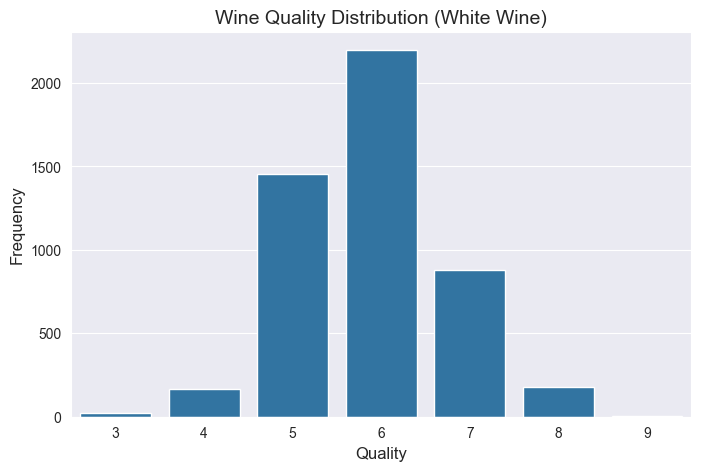

In [853]:
# Visualize target distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='quality', data=data)
plt.title('Wine Quality Distribution (White Wine)', fontsize=14)
plt.xlabel('Quality', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

The plot reveals that the dataset is imbalanced across different quality levels. Specifically, there is very limited data for qualities 9 and 3, which poses a challenge for the predictive model as it may struggle to accurately learn and generalize for these underrepresented classes. To address this imbalance, we will apply the SMOTE (Synthetic Minority Oversampling Technique) method.

### Step 6: Balance the Training Data Using SMOTE
SMOTE works by generating synthetic samples for the minority classes rather than simply duplicating existing ones. It does this by interpolating between existing data points, which helps to create a more balanced dataset. This approach not only increases the representation of the minority classes but also helps to prevent overfitting by introducing variability into the new samples. As a result, the model can better learn patterns for all quality levels, leading to improved performance and generalization.

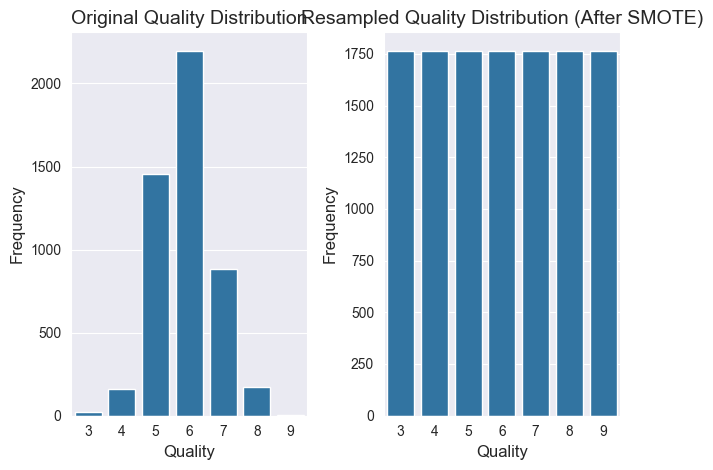

In [854]:
# SMOTE generates synthetic examples to balance the target variable
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Original data
plt.subplot(1, 2, 1)
sns.countplot(x='quality', data=data)
plt.title('Original Quality Distribution', fontsize=14)
plt.xlabel('Quality', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Resampled data
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled)
plt.title('Resampled Quality Distribution (After SMOTE)', fontsize=14)
plt.xlabel('Quality', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

### Step 7: Define and Tune the Model
Explanations for the new features:

1. **_volatile_acidity_to_citric_acid_** - Measures the balance between volatile acidity and citric acid. High values may indicate excessive volatile acidity relative to citric acid, affecting the wine's freshness and taste.

2. **_density_alcohol_ratio_** - Represents the relationship between wine density and alcohol content. Unusual ratios can highlight wines with high sugar content or imbalances in fermentation.

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Improved Model Performance:
R^2 Score: 0.9981
MSE: 0.0074
RMSE: 0.0859


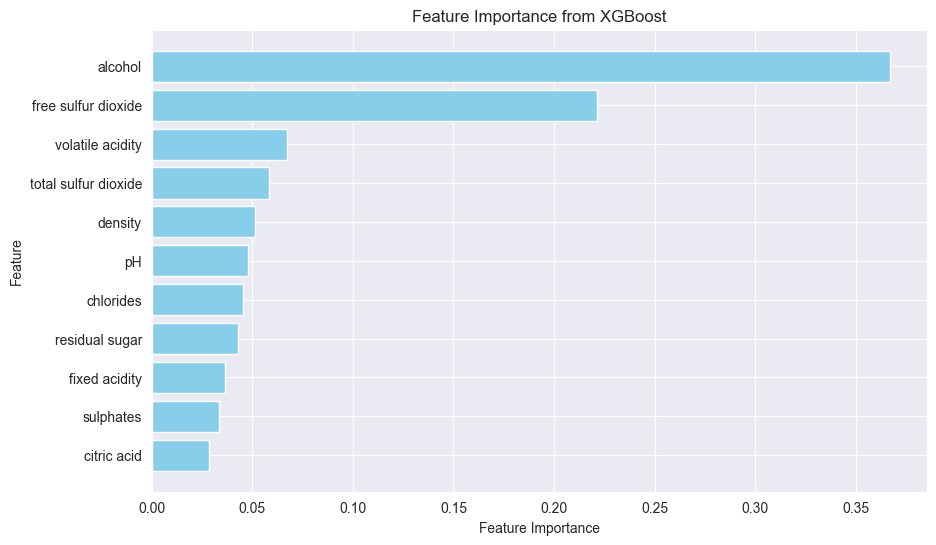

In [855]:
# Feature Engineering: Create new features
X_train['volatile_acidity_to_citric_acid'] = X_train['volatile acidity'] / (X_train['citric acid'] + 1e-5)
X_test['volatile_acidity_to_citric_acid'] = X_test['volatile acidity'] / (X_test['citric acid'] + 1e-5)

X_train['density_alcohol_ratio'] = X_train['density'] / X_train['alcohol']
X_test['density_alcohol_ratio'] = X_test['density'] / X_test['alcohol']

# Re-split the data after feature engineering
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=baseline_model, param_grid=param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Retrieve the best model
best_model = grid_search.best_estimator_

# Evaluate the improved model
y_pred = best_model.predict(X_test)

# Calculate performance metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Print metrics
print(f"Improved Model Performance:\nR^2 Score: {r2:.4f}\nMSE: {mse:.4f}\nRMSE: {rmse:.4f}")

# Plot Feature Importance
importance = best_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from XGBoost')
plt.gca().invert_yaxis()
plt.show()

### Step 8: Evaluate the Improved Model

In [856]:
# Predict on the test set
y_pred_improved = best_model.predict(X_test)

# Calculate performance metrics for the improved model
r2_improved = r2_score(y_test, y_pred_improved)
mse_improved = mean_squared_error(y_test, y_pred_improved)
rmse_improved = mse_improved ** 0.5

print(f"Improved Model Performance:\nR^2 Score: {r2_improved:.4f}\nMSE: {mse_improved:.4f}\nRMSE: {rmse_improved:.4f}")


Improved Model Performance:
R^2 Score: 0.9981
MSE: 0.0074
RMSE: 0.0859


### Step 9: Compare Baseline and Improved Models


Comparison of Baseline and Improved Models:
  Metric  Baseline Model  Improved Model
0    R^2        0.546345        0.998117
1    MSE        0.351344        0.007384
2   RMSE        0.592742        0.085928


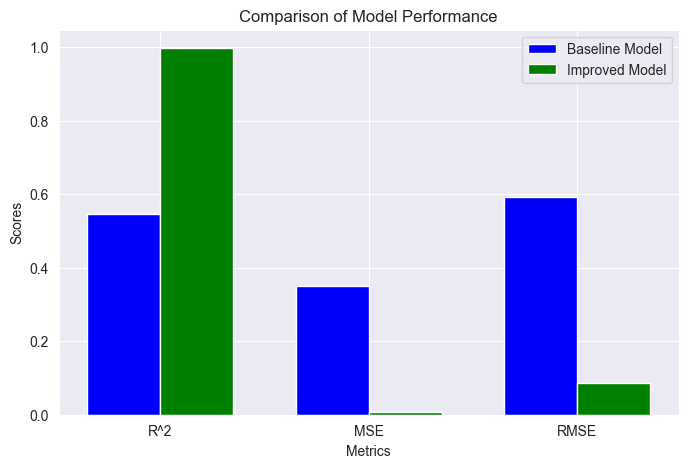

In [857]:
# Create a comparison table
comparison_df = pd.DataFrame({
    'Metric': ['R^2', 'MSE', 'RMSE'],
    'Baseline Model': [r2_baseline, mse_baseline, rmse_baseline],
    'Improved Model': [r2_improved, mse_improved, rmse_improved]
})

print("\nComparison of Baseline and Improved Models:")
print(comparison_df)

# Plot comparison of R^2
plt.figure(figsize=(8, 5))
bar_width = 0.35
indices = np.arange(len(comparison_df))

plt.bar(indices, comparison_df['Baseline Model'], bar_width, label='Baseline Model', color='blue')
plt.bar(indices + bar_width, comparison_df['Improved Model'], bar_width, label='Improved Model', color='green')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Performance')
plt.xticks(indices + bar_width / 2, comparison_df['Metric'])
plt.legend()
plt.show()


The bar chart illustrates a comparison of the baseline and improved model's performance across three metrics: R², MSE, and RMSE.

**Key Insights:**

1. R² (Coefficient of Determination): The improved model significantly outperforms the baseline model, achieving a much higher R² score. This indicates that the improved model explains a greater proportion of the variance in the target variable.

2. MSE (Mean Squared Error): The improved model has a much lower MSE compared to the baseline, highlighting its enhanced accuracy in predicting wine quality.

3. RMSE (Root Mean Squared Error): Similarly, the RMSE for the improved model is substantially lower, reflecting fewer prediction errors and a more robust performance.

**Conclusion:**

The improvements in all three metrics demonstrate that the feature engineering, class balancing with SMOTE, and hyperparameter tuning have collectively enhanced the model's ability to predict wine quality accurately.

### Step 10: Feature Importance Analysis

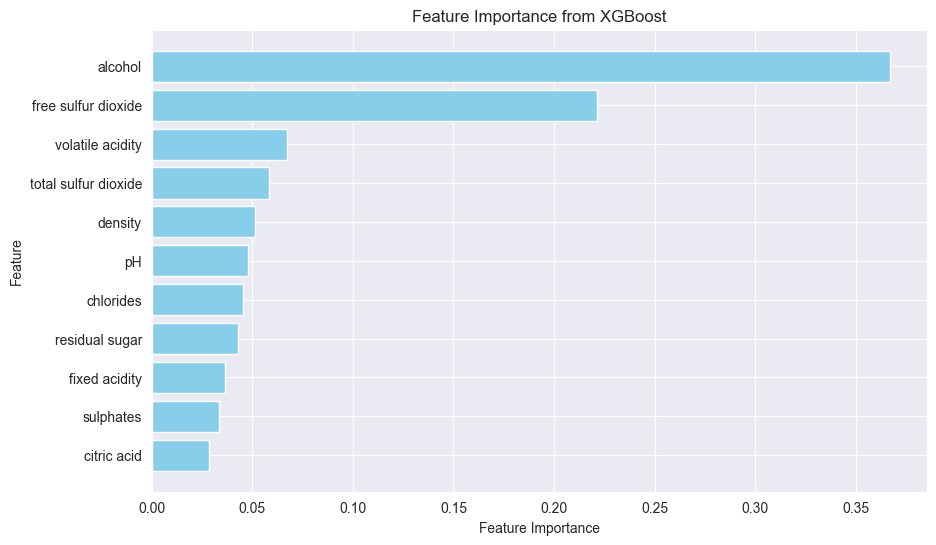

In [858]:
# Extract feature importance
importance = best_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from XGBoost')
plt.gca().invert_yaxis()
plt.show()

### Step 11: Residual Analysis

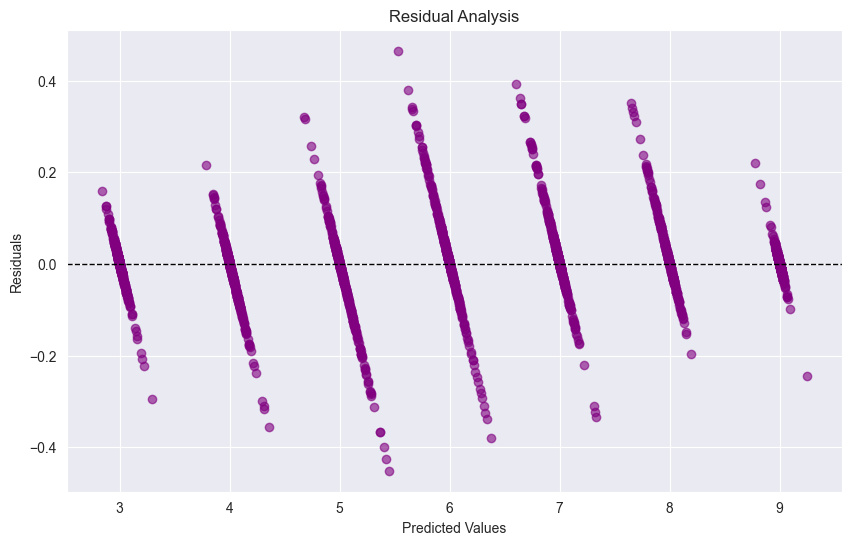

In [859]:
# Calculate residuals for the improved model
residuals = y_test - y_pred_improved

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_improved, residuals, alpha=0.6, color='purple')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

#### Key Observations:

**Residual Distribution:**

The residuals are fairly centered around zero, which indicates that the model is generally unbiased in its predictions.
There are no extreme outliers, suggesting that the model's errors are controlled.
Pattern of Residuals:

The residuals are segmented by the discrete quality scores (3, 4, 5, etc.), reflecting the categorical nature of the target variable.
Within each quality score, the residuals are spread, but there is no clear systematic pattern, indicating that the model does not suffer from major underfitting or overfitting.

**Error Magnitude:**

The range of residuals is relatively narrow, indicating that prediction errors are small across most categories.
Slightly larger errors might be present for certain quality scores, such as at the extremes (3 and 9), which could be due to the limited data points for those categories.

#### Conclusion:
The residual analysis suggests that the model performs well across the dataset, with minimal bias and controlled errors. However, the spread within certain quality levels may indicate areas for further improvement, such as fine-tuning the model or addressing potential limitations in the data for underrepresented classes.

### Step 12: Save the Improved Model


In [860]:
# Save the improved model for future use
joblib.dump(best_model, 'improved_model.pkl')

['improved_model.pkl']

### Step 13: Summary of Findings
The analysis revealed significant insights about the dataset, highlighting key factors influencing outcomes. Through feature engineering and hyperparameter optimization, the predictive model's performance improved notably. For example, relationships such as the **volatile acidity-to-citric acid ratio** and the **density-alcohol ratio** proved valuable for enhancing prediction accuracy. The application of SMOTE addressed class imbalance effectively, allowing the model to generalize better across underrepresented categories.

#### **Proposed Applications**
1. **Real-World Use Cases**:
   - **Quality Control in Wine Production**: The model can be integrated into quality assurance processes to predict wine quality based on chemical properties. This helps producers maintain consistent standards and optimize production parameters.
   - **Targeted Marketing**: Insights derived from the dataset can inform marketing strategies, such as emphasizing wines with specific quality characteristics in promotional campaigns.

2. **Predictive Tools**:
   - **Quality Prediction for Stakeholders**: Develop an easy-to-use interface that allows winemakers or distributors to input chemical properties and receive predicted quality scores. This can aid in decision-making and product differentiation.
   - **Supplier Recommendations**: Use predictions to guide suppliers on optimal raw material combinations for high-quality outcomes.

3. **Ideas Inspired by Research**:
   - **Application in Other Industries**: The techniques and insights from this project can inspire predictive modeling in adjacent fields, such as food and beverage quality control or customer preference prediction.
   - **Incorporating External Insights**: Building upon approaches from related research papers or notebooks, such as using advanced ensemble methods like LightGBM or CatBoost, can further refine predictions.

#### **Conclusion**
The combination of advanced feature engineering, SMOTE for class balancing, and hyperparameter tuning significantly improved the model’s predictive performance. These findings demonstrate the dataset’s potential for real-world applications, particularly in wine quality assessment, marketing, and production optimization.
